# Causal Model Fairness: Un caso de estudio

En este ejercicio usaremos un conjunto de datos que contiene información de un modelo conocido por su sesgo: el algoritmo COMPAS, que predecía el riesgo de reincidencia para su uso en sentencias penales.

Usaremos los datos que contienen las puntuaciones COMPAS para reincidencia violenta

Links relevantes con más contexto:

* [El articulo con la historia](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)


In [ ]:
# %%capture
!pip install --upgrade numpy==1.23.5 dowhy seaborn statsmodels

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api
from dowhy import CausalModel
from math import exp
# plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years-violent.csv')
df.shape

In [ ]:
df.columns

In [ ]:
df.head()

## Datos y contexto

Lo que buscamos es entender hasta qué punto la puntuación predicha por COMPAS está sesgada según la raza del acusado. Utilizamos las siguientes columnas:
* `c_charge_degree`: el grado del cargo (delito menor o grave)
* `age_cat`: una codificación categórica de la edad del acusado
* `race`: la raza del acusado, que sirve como el enfoque de este análisis
* `sex`: el sexo del acusado, codificado como `Female` (Femenino) y `Male` (Masculino)
* `priors_count`: el recuento bruto de las condenas previas del acusado
* `two_year_recid`: si el acusado realmente reincidió en los dos años posteriores a la sentencia (es decir, el objetivo que el modelo intenta predecir)
* `score_text`: la probabilidad de reincidencia predicha por el modelo COMPAS, agrupada en `Low` (Bajo), `Medium` (Medio) y `High` (Alto)
  * Se  binarizan en puntuaciones bajas frente a medias y altas, lo que utilizan como la variable respuesta en un GLM (Modelo Lineal Generalizado)

En nuestro análisis la variable respuesta será `correct`, un valor booleano que indica si el modelo COMPAS identificó correctamente el riesgo de reincidencia de un individuo.

In [ ]:
fairness_df = df\
  .query("days_b_screening_arrest <= 30")\
  .query("days_b_screening_arrest >= -30")\
  .query("is_recid != -1")\
  .query("c_charge_degree != 'O'")\
  .query("score_text != 'N/A'")\
  .assign(predicted_recid = lambda x: (x.score_text != 'Low').astype(int),
          correct = lambda x: (x.predicted_recid == x.two_year_recid).astype(int),
          juvenile_offenses = lambda x: x.juv_fel_count + x.juv_misd_count + x.juv_other_count)\
  [['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
    'priors_count', 'decile_score', 'juvenile_offenses',
    'is_recid', 'two_year_recid', 'predicted_recid', 'correct']]

fairness_df.shape

In [ ]:
fairness_df['is_recid'].value_counts(dropna=False)

In [ ]:
fairness_df['two_year_recid'].value_counts(dropna=False)

In [ ]:
fairness_df['predicted_recid'].value_counts(dropna=False)

In [ ]:
fairness_df['correct'].head()

In [ ]:
fairness_df['race'].value_counts(dropna=False)

In [ ]:
#filtramos sólo caucásico y afroamericano
fairness_df = fairness_df[fairness_df['race'].isin(['Caucasian', 'African-American'])]

## Análisis Exploratorio

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=fairness_df, x="race", y="correct", width=0.6,palette=["blue", "orange"])
plt.title("COMPAS Model Accuracy by Race", fontsize=16)
plt.xlabel(None)
plt.ylabel("% Correctly Classified")
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=fairness_df, x="race", y="predicted_recid", width=0.6,palette=["blue", "orange"])
plt.title("COMPAS Model Predictions by Race", fontsize=16,)
plt.xlabel(None)
plt.ylabel("% Predicted as Medium- or High- Risk")
plt.show()

Cómo difiere la reincidencia actual por raza:

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 8))

sns.barplot(data=fairness_df[fairness_df['predicted_recid'] == 0],
            x="race", y="two_year_recid", width=0.6, ax=ax[0],palette=["blue", "orange"])
ax[0].set_title("Actual Recidivism by Race: Low Predicted Risk", fontsize=14)
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)

sns.barplot(data=fairness_df[fairness_df['predicted_recid'] == 1],
            x="race", y="two_year_recid", width=0.6, ax=ax[1],palette=["blue", "orange"])
ax[1].set_title("Actual Recidivism by Race: Medium or High Predicted Risk", fontsize=14)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)

plt.tight_layout(h_pad=1.5)
plt.show()

In [ ]:
fairness_df.groupby("race").agg({'correct':'mean'})

In [ ]:
fairness_df.groupby("race").agg({'predicted_recid':'mean'})

## Disparidad en la tasa de clasificación correcta (Accuracy) del modelo


### Inferencia Causal

Usaremos la librería `dowhy` para plantear el problema como uno de inferencia causal.

In [ ]:
def group_juvenile_offenses(count):
  if count == 0:
    return '0'
  elif count <= 2:
    return '1-2'
  else:
    return '3+'

def group_priors(count):
  if count == 0:
    return '0'
  elif count <= 3:
    return '1-3'
  elif count <= 8:
    return '4-8'
  else:
    return '9+'

fairness_df['juvenile_offenses_grouped'] = fairness_df['juvenile_offenses'].apply(group_juvenile_offenses)
fairness_df['priors_grouped'] = fairness_df['priors_count'].apply(group_priors)

In [ ]:
fairness_df.groupby('juvenile_offenses_grouped').agg({'predicted_recid':['count', 'mean']})

In [ ]:
fairness_df.groupby('priors_grouped', dropna=False).agg({'predicted_recid':['count', 'mean']})

Deinimos nuestro gráfico causal usando Graph Markup Language, con las siguientes variables

* X: raza
* Y: accuracy del modelo COMPAS
* Z1: género
* Z2: edad
* J: conteo de ofensas juveniles
* P: número de ofensas previas (prior offense count)
* D: grado / gravedad del cargo

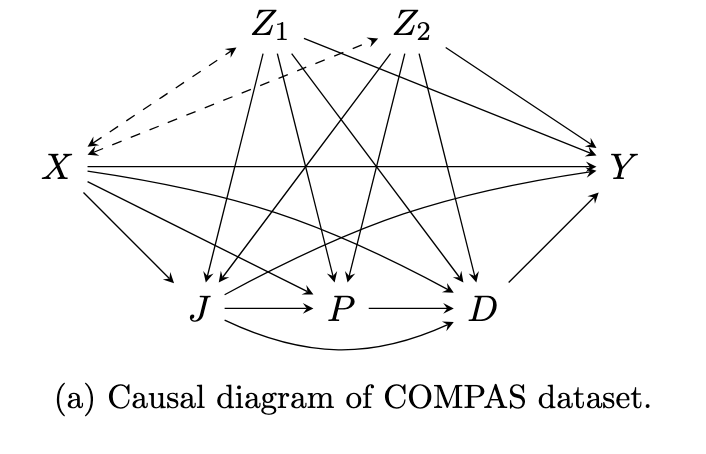

In [ ]:
causal_graph_accuracy = """
graph [
  comment "Causal graph for the COMPAS dataset"
  directed 1
  IsPlanar 1
  node [
    id "race"
    label "race"
  ]
  node [
    id "correct"
    label "correct"
  ]
  node [
    id "sex"
    label "sex"
  ]
  node [
    id "age_cat"
    label "age_cat"
  ]
  node [
    id "juvenile_offenses_grouped"
    label "juvenile_offenses_grouped"
  ]
  node [
    id "priors_grouped"
    label "priors_grouped"
  ]
  node [
    id "c_charge_degree"
    label "c_charge_degree"
  ]
  edge [
    source "race"
    target "correct"
    label "Discriminatory Effect"
  ]
  edge [
    source "race"
    target "juvenile_offenses_grouped"
    label "Edge from race to juvenile offense count"
  ]
  edge [
    source "race"
    target "priors_grouped"
    label "Edge from race to prior offense count"
  ]
  edge [
    source "race"
    target "c_charge_degree"
    label "Edge from race to charge degree"
  ]
  edge [
    source "sex"
    target "correct"
    label "Edge from sex to outcome"
  ]
  edge [
    source "sex"
    target "juvenile_offenses_grouped"
    label "Edge from sex to juvenile offense count"
  ]
  edge [
    source "sex"
    target "priors_grouped"
    label "Edge from sex to prior offense count"
  ]
  edge [
    source "sex"
    target "c_charge_degree"
    label "Edge from sex to charge degree"
  ]
  edge [
    source "age_cat"
    target "correct"
    label "Edge from age to outcome"
  ]
  edge [
    source "age_cat"
    target "juvenile_offenses_grouped"
    label "Edge from age to juvenile offense count"
  ]
  edge [
    source "age_cat"
    target "priors_grouped"
    label "Edge from age to prior offense count"
  ]
  edge [
    source "age_cat"
    target "c_charge_degree"
    label "Edge from age to charge degree"
  ]

  edge [
    source "juvenile_offenses_grouped"
    target "priors_grouped"
    label "Edge from juvenile count to prior count"
  ]
  edge [
    source "juvenile_offenses_grouped"
    target "c_charge_degree"
    label "Edge from juvenile count to charge degree"
  ]
  edge [
    source "juvenile_offenses_grouped"
    target "correct"
    label "Edge from juvenile count to outcome"
  ]
  edge [
    source "priors_grouped"
    target "c_charge_degree"
    label "Edge from prior count to charge degree"
  ]
  edge [
    source "c_charge_degree"
    target "correct"
    label "Edge from charge degree to outcome"
  ]
]
"""

La estructura de este grafo se alinea con el **Standard Fairness Model (SFM)** usando las variables del conjunto de datos COMPAS.

* **Atributo Protegido ($X$):** `race`
* **Resultado ($Y$):** `correct`
* **Confundidores ($Z$):** `sex`, `age_cat`
* **Mediadores ($W$):** `juvenile_offenses_grouped`, `priors_grouped`, `c_charge_degree`

Este grafo formaliza las suposiciones sobre cómo estos factores se influyen mutuamente. Por ejemplo, asume que la raza `race` puede tener un efecto directo en la precisión del modelo (`correct`), pero también un efecto indirecto a través de su influencia en factores como el número de condenas previas.

In [ ]:
#necesitamos codificar la variable race:
causal_df = fairness_df\
  .assign(race=lambda x: x.race.map({'Caucasian':0, 'African-American':1}))

#Aquí estamos definiendo el modelo causal.
# Al especificar que el tratamiento es la variable "race" definimos cuál es la
# causa que queremos investigar. En el contexto de fairness, este es el atributo protegido

# outcome = "correct" --> cuál es el resultado o efecto que queremos

# medir. Al especificar graph=causal_graph_accuracy es donde se incorpora el
# conocimiento experto, el cual contiene las suposiciones sobre cómo las
# variables se relacionan entre sí.

causal_model_accuracy = CausalModel(data=causal_df, treatment="race", outcome="correct", graph=causal_graph_accuracy)
causal_model_accuracy.view_model() #sólo para ver el grafo

In [ ]:
identified_estimand_accuracy = causal_model_accuracy.identify_effect()
print(identified_estimand_accuracy)

### **Explicación e Interpretaciones**

En el paso anterior, causal_model_accuracy.identify_effect() aún no calcula un número específico. Su objetivo es encontrar una fórmula estadística para medir el efecto causal. A esta "fórmula" o estrategia se le conoce como "Estimand".

Además, nos indica que el objetivo es calcular el **Efecto Promedio del Tratamiento (ATE)**.

En nuestro contexto, lo que queremos saber es en promedio, **¿cuál es el impacto causal de la raza de un acusado en la exactitud del modelo?**

La estrategia o método principal usado fue Ruta Trasera o **"Backdoor"** (la forma de identificación más común y robusta).

En nuestro caso, para aislar el efecto causal $race \rightarrow correct$ necesitamos bloquear todos los backdoor paths (rutas traseras) que crean correlaciones falsas.

Por ejemplo, una ruta trasera es $race \leftarrow age \rightarrow correct$
La edad (age_cat) es un confounder que influye tanto en la demografía racial de los acusados como en el resultado. La estrategia "backdoor" consiste en "ajustar por" o "controlar" estos confundidores (age_cat y sex) para cerrar estas rutas y aislar el efecto real.

La Expresión: `d/d[race](E[correct])` es una manera formal para expresar la pregunta causal: "¿Cómo cambia el valor esperado de `correct` si pudiéramos **intervenir** y cambiar el valor de `race`?". Esto es es lo que lo hace distinto de una simple correlación.



In [ ]:
#Aquí es donde se calcula el efecto causal. Le pasamos identified_estimand_accuracy
# del paso anterior.

# Además, especificamos el método para la estimación
estimate_accuracy = causal_model_accuracy.estimate_effect(
    identified_estimand_accuracy,
    control_value=0,
    treatment_value=1,
    method_name="backdoor.generalized_linear_model",
    method_params={'glm_family':statsmodels.api.families.Binomial()}
)

estimate_accuracy.value

In [ ]:
estimate_accuracy.get_confidence_intervals()

In [ ]:
estimate_accuracy.test_stat_significance()

In [ ]:
estimate_accuracy.interpret()

El `-0.116` es el **Efecto Promedio del Tratamiento (ATE)**, que podemos interpretar de la siguiente manera:

"Después de "bloquear" estadísticamente la influencia de los confounders (edad y sexo), el ser un acusado Afroamericano en lugar de Caucásico **causa una disminución promedio de 0.116 en la probabilidad de que la predicción del modelo sea correcta**.

Dicho de otra forma el modelo es, en promedio, **11.6 puntos porcentuales menos preciso** para los acusados Afroamericanos que para los acusados Caucásicos que son estadísticamente similares en edad y sexo. Es una medida del sesgo del modelo.